In [1]:
import gym
from collections import deque
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device_check:', device)

device_check: cuda


In [2]:
## hyperparameter
LR = 0.0005
GAMMA = 0.98
BUFFER_LIMIT = 50000
BATCH_SIZE = 32

Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state', 'done'))

In [3]:
class ReplayBuffer():
    def __init__(self):
        self.buffer = deque([], maxlen=BUFFER_LIMIT)  # double-ended queue

    def push(self, *args):  ## deque --> append
        self.buffer.append(Transition(*args))

    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, next_state, done = transition
            s_lst.append(s);
            a_lst.append([a]);
            r_lst.append([r]);
            s_prime_lst.append(next_state);
            done_mask_lst.append([done])

        def list_to_tensor_float(lst):
            return torch.tensor(lst, dtype=torch.float).to(device)

        def list_to_tensor(lst):
            return torch.tensor(lst).to(device)

        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = list_to_tensor_float(s_lst), list_to_tensor(
            a_lst), list_to_tensor(r_lst), list_to_tensor_float(s_prime_lst), list_to_tensor(done_mask_lst)

        return s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst

    def size(self):
        return len(self.buffer)

In [4]:
class DuelingQnet(nn.Module):
    def __init__(self, input_size, output_size):

        super(DuelingQnet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc_value = nn.Linear(128, 64)
        self.fc_adv = nn.Linear(128, 64)
        self.value = nn.Linear(64, 1)
        self.adv = nn.Linear(64, output_size)

    def forward(self, x):

        x = x.to(device)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        v = F.relu(self.fc_value(x))
        a = F.relu(self.fc_adv(x))
        v = self.value(v)
        a = self.adv(a)
        a_avg = torch.mean(a)
        q = v + a - a_avg
        return q

    def sample_action(self, obs, epsilon):
        out = self.forward(obs)
        coin = random.random()
        if coin < epsilon:
            return random.randint(0, 1)
        else:
            return out.argmax().item()

In [5]:
def train(q, q_target, memory, optimizer):
    for i in range(200):  
        s, a, r, s_prime, done_mask = memory.sample(BATCH_SIZE)

        q_out = q(s)
        q_a = q_out.gather(1, a)
        max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)  ## target_network
        target = r + GAMMA * max_q_prime * done_mask
        loss = F.mse_loss(q_a, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Iteration:1, Reward : -210.0
Iteration:2, Reward : -200.0
Iteration:3, Reward : -200.0
Iteration:4, Reward : -200.0
Iteration:5, Reward : -200.0
Iteration:6, Reward : -200.0
Iteration:7, Reward : -200.0
Iteration:8, Reward : -200.0
Iteration:9, Reward : -200.0
Iteration:10, Reward : -200.0
Iteration:11, Reward : -200.0
Iteration:12, Reward : -200.0
Iteration:13, Reward : -200.0
Iteration:14, Reward : -200.0
Iteration:15, Reward : -200.0
Iteration:16, Reward : -200.0
Iteration:17, Reward : -200.0
Iteration:18, Reward : -200.0
Iteration:19, Reward : -200.0
Iteration:20, Reward : -200.0
Iteration:21, Reward : -200.0
Iteration:22, Reward : -200.0
Iteration:23, Reward : -200.0
Iteration:24, Reward : -200.0
Iteration:25, Reward : -200.0
Iteration:26, Reward : -200.0
Iteration:27, Reward : -200.0
Iteration:28, Reward : -200.0
Iteration:29, Reward : -200.0
Iteration:30, Reward : -200.0
Iteration:31, Reward : -200.0
Iteration:32, Reward : -200.0
Iteration:33, Reward : -200.0
Iteration:34, Rewar

Iteration:269, Reward : -200.0
Iteration:270, Reward : -200.0
Iteration:271, Reward : -200.0
Iteration:272, Reward : -195.7
Iteration:273, Reward : -197.6
Iteration:274, Reward : -197.9
Iteration:275, Reward : -200.0
Iteration:276, Reward : -192.8
Iteration:277, Reward : -200.0
Iteration:278, Reward : -195.1
Iteration:279, Reward : -183.8
Iteration:280, Reward : -191.8
Iteration:281, Reward : -192.9
Iteration:282, Reward : -188.1
Iteration:283, Reward : -189.7
Iteration:284, Reward : -196.1
Iteration:285, Reward : -186.8
Iteration:286, Reward : -188.8
Iteration:287, Reward : -188.6
Iteration:288, Reward : -199.0
Iteration:289, Reward : -190.9
Iteration:290, Reward : -197.2
Iteration:291, Reward : -188.7
Iteration:292, Reward : -200.0
Iteration:293, Reward : -190.9
Iteration:294, Reward : -188.2
Iteration:295, Reward : -195.2
Iteration:296, Reward : -200.0
Iteration:297, Reward : -199.2
Iteration:298, Reward : -194.3
Iteration:299, Reward : -198.6
Iteration:300, Reward : -192.1
Iteratio

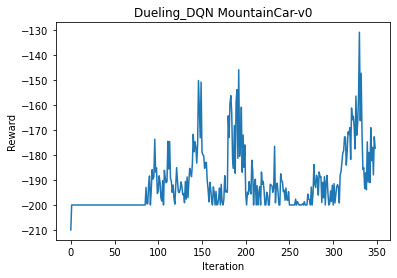

In [6]:
def start_train():
    env = gym.make('MountainCar-v0')

    input_size = env.observation_space.shape[0]
    output_size = env.action_space.n

    iteration = 0
    num_traj = 20 
    score = 0

    reward_list = []

    q = DuelingQnet(input_size, output_size).to(device)
    q_target = DuelingQnet(input_size, output_size).to(device)

    q_target.load_state_dict(q.state_dict())  ## 모델 불러오기 
    memory = ReplayBuffer()

    optimizer = optim.Adam(q.parameters(), lr=LR)  ## Apply Adam Optimizer

    for n_epi in range(7000):  ## iteration 횟수와 관련
        epsilon = max(0.01, 0.07 - 0.01 * (n_epi / 200))  # Linear annealing from 8% to 1%
        s = env.reset()
        done = False

        while not done:  ##
            a = q.sample_action(torch.from_numpy(s).float(), epsilon)
            s_prime, r, done, info = env.step(a)  ## state, reward, terminal_state (1? NO, 0? Yes), probability
            done_mask = 0.0 if done else 1.0  ## 끝났으면 0 이다.
            memory.push(s, a, r / 100.0, s_prime, done_mask) 
            s = s_prime

            score += r  ## reward 합 t
            if done:
                break

        if memory.size() > 2000:  ### memeory_size가 2000 넘으면 학습시작
            train(q, q_target, memory, optimizer)

        if n_epi % num_traj == 0 and n_epi != 0:
            iteration += 1

            q_target.load_state_dict(q.state_dict())  ## 학습된 모델 불러오기)

            print("Iteration:{}, Reward : {:.1f}".format(iteration, score / num_traj))

            reward_list.append(score / num_traj)
            score = 0.0

    env.close()

    return reward_list


if __name__ == '__main__':
    mean_return_list = start_train()
    plt.plot(mean_return_list)
    plt.xlabel('Iteration')
    plt.ylabel('Reward')
    plt.title('Dueling_DQN MountainCar-v0')
    plt.savefig('MountainCar_dueling_dqn.png', format='png', dpi=300)